# Steam Game Success Prediction

This notebook builds and evaluates models to predict whether a Steam game will be **successful** based on a mixture of
game metadata and user review signals.

Concretely, we combine:

- `steam_games.json`: one row per Steam title with basic metadata such as name, price, genres, categories, and release date.  
- `australian_user_reviews.json`: per–user reviews, which we flatten into one row per `(user, game)` pair containing
  a binary recommendation flag and a short text review.

Our **predictive task** is a binary classification problem:

- **Input features:** simple, tabular descriptors of each game (release year, price, number of genres, review counts,
  share of positive reviews, log–transformed review count, etc.).
- **Target label:** whether a game should be considered “successful” according to its review history (defined later).
- **Goal:** learn a model that can predict success for new games using only these features.

The workflow of the notebook mirrors the structure expected for the Assignment 2 project:

1. Data loading and basic cleaning  
2. Lightweight exploratory data analysis (EDA)  
3. Feature engineering at the game level  
4. Defining a success label  
5. Train / validation / test split  
6. Baseline models (majority class, logistic regression)  
7. Improved models (tree–based ensembles with modest hyperparameter tuning)  
8. Evaluation and model selection  
9. Error analysis and qualitative inspection of predictions  

Throughout, the focus is on making the code and narrative easy to follow so that peer graders can read the notebook
without needing to re–run any cells.


In [1]:
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    classification_report,
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast


## 1. Data loading

We first load the two JSON‑lines files provided for the project:

- `steam_games.json`: metadata for each game (an `id`, title, price, genres, categories, and release date).  
- `australian_user_reviews.json`: nested per–user dictionaries, where each line contains a `user_id` and a list of
  that user’s reviews.

Because the files are stored as one JSON object per line, we stream them line‑by‑line, parse each line with
`ast.literal_eval`, and collect the results into Python lists before converting them to Pandas DataFrames.

A few small but important cleaning steps:

- For the games table we rename the column `id` to `item_id` (if needed) and cast it to string.  
- For the reviews table we flatten the nested structure so that each row corresponds to a single review, and we attach
  the `user_id` to each review.  
- We then standardize the game identifier in the reviews table by renaming any of `appid`, `app_id`, or `id` to
  `item_id` and casting it to string so that it can be joined to the games table later.

At the end of this step we have two clean DataFrames, `games_df` and `reviews_df`, keyed on a common `item_id`
identifier.


In [2]:
# Adjust the paths here if your data lives somewhere else
GAMES_PATH = "steam_games.json"
REVIEWS_PATH = "australian_user_reviews.json"

# ---- Load steam_games.json ----
games = []
with open(GAMES_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            games.append(ast.literal_eval(line))
        except Exception as e:
            # If there are any malformed lines, just skip them
            print(f"Skipping bad line in games file: {e}")

games_df = pd.DataFrame(games)

# Make sure we have an item_id column as string
if "id" in games_df.columns and "item_id" not in games_df.columns:
    games_df = games_df.rename(columns={"id": "item_id"})
games_df["item_id"] = games_df["item_id"].astype(str)

print("Games shape:", games_df.shape)
games_df.head()

print(games_df.columns)


Games shape: (32135, 16)
Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'discount_price', 'reviews_url', 'specs', 'price',
       'early_access', 'item_id', 'developer', 'sentiment', 'metascore'],
      dtype='object')


In [3]:
# ---- Load australian_user_reviews.json ----
reviews = []
with open(REVIEWS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            user_data = ast.literal_eval(line)
            user_id = user_data.get("user_id")
            for review in user_data.get("reviews", []):
                # Each review is a dict; copy it so we can safely mutate
                review_entry = dict(review)
                review_entry["user_id"] = user_id
                reviews.append(review_entry)
        except Exception as e:
            print(f"Skipping bad line in reviews file: {e}")

reviews_df = pd.DataFrame(reviews)

# Standardize the item id column
if "item_id" not in reviews_df.columns:
    # Some datasets call this appid, game_id, etc.; adjust if needed.
    for candidate in ["appid", "app_id", "id"]:
        if candidate in reviews_df.columns:
            reviews_df = reviews_df.rename(columns={candidate: "item_id"})
            break

reviews_df["item_id"] = reviews_df["item_id"].astype(str)

print("Reviews shape:", reviews_df.shape)
reviews_df.head()

print(reviews_df.columns)


Reviews shape: (59305, 8)
Index(['funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend',
       'review', 'user_id'],
      dtype='object')


## 2. Quick EDA

Before committing to any modeling choices, we do a light sanity check on the games and reviews:

- Count how many unique games appear in `games_df` versus `reviews_df`.  
- Inspect the set of columns in each DataFrame to confirm that the expected fields are present.  
- Compute how many reviews each game has and plot the distribution of review counts.

The review histogram confirms a highly skewed distribution: a small number of popular titles accumulate thousands of
reviews, while the long tail of games has only a handful of reviews. This motivates using both the **number of reviews**
and the **share of positive reviews** when defining a success label, and suggests that we should be cautious about
learning from games with only one or two reviews.


Unique games in games_df: 32133
Unique games in reviews_df: 3682

Reviews per game (head):
item_id
730       3759
440       3736
4000      1735
570       1562
218620    1137
Name: count, dtype: int64


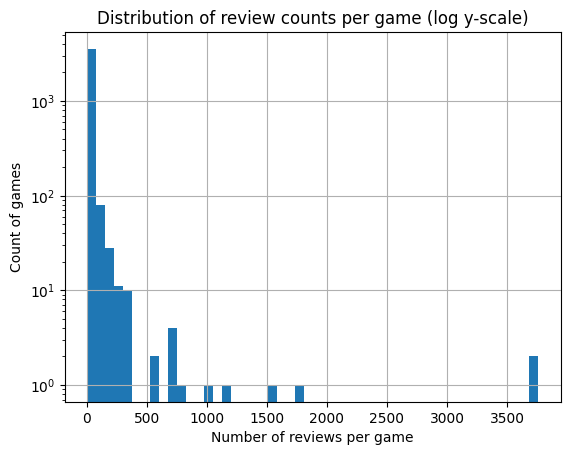

In [4]:
# Number of unique games in each table
print("Unique games in games_df:", games_df["item_id"].nunique())
print("Unique games in reviews_df:", reviews_df["item_id"].nunique())

# Reviews per game
reviews_per_game = reviews_df["item_id"].value_counts()
print("\nReviews per game (head):")
print(reviews_per_game.head())

plt.figure()
reviews_per_game.hist(bins=50)
plt.xlabel("Number of reviews per game")
plt.ylabel("Count of games")
plt.yscale("log")
plt.title("Distribution of review counts per game (log y-scale)")
plt.show()


## 3. Feature engineering (per–game aggregates)

Our raw data lives at the **review level**: we have many rows per game, one per user review. For the prediction task we
want **one feature vector per game**, so we aggregate reviews into game‑level statistics.

From the `recommend` flag and other review fields we construct:

- `n_reviews`: number of reviews a game has received.  
- `n_pos`: number of reviews that recommend the game.  
- `pos_share`: fraction of reviews that recommend the game (`n_pos / n_reviews`).  
- `log_n_reviews`: a log‑transformed version of the review count, which compresses the heavy tail of extremely popular
  games while still distinguishing between, say, 10 and 1000 reviews.

These aggregates capture both **popularity** (how many people reviewed the game) and **satisfaction** (how many of
those reviews were positive). We keep the implementation robust by checking which columns are available in the dataset
(e.g., different versions may store recommendation flags under slightly different names) and gracefully skipping
missing ones.


In [ ]:
POS_THRESHOLD = 0.75
MIN_REVIEWS_FOR_LABEL = 2


game_review_features = (
    reviews_df.groupby("item_id")
    .agg(
        n_reviews=("recommend", "size"),
        n_pos=("recommend", lambda s: (s == True).sum()),
    )
    .reset_index()
)

# Positive share: fraction of reviews that recommend the game
game_review_features["pos_share"] = (
    game_review_features["n_pos"] / game_review_features["n_reviews"]
)


# Binary success label from pos_share
game_review_features["success"] = (
    (game_review_features["n_reviews"] >= MIN_REVIEWS_FOR_LABEL)
    & (game_review_features["pos_share"] >= POS_THRESHOLD)
).astype(int)


# Log-transformed review count
game_review_features["log_n_reviews"] = np.log1p(game_review_features["n_reviews"])

# Keep what we need going forward
game_review_features = game_review_features[
    ["item_id", "n_reviews", "log_n_reviews", "pos_share", "success"]
]


print(game_review_features.head())
print("Game review feature shape:", game_review_features.shape)
print(game_review_features.describe())


Reviews shape: (59305, 8)
Review columns: ['funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend', 'review', 'user_id']
  item_id  n_reviews  log_n_reviews  pos_share  success
0      10         57       4.060443   0.982456        1
1   10090         52       3.970292   0.980769        1
2   10130          2       1.098612   1.000000        1
3   10140          1       0.693147   1.000000        0
4   10150          9       2.302585   1.000000        1
Game review feature shape: (3682, 5)
         n_reviews  log_n_reviews    pos_share      success
count  3682.000000    3682.000000  3682.000000  3682.000000
mean     16.106735       1.567735     0.803689     0.433732
std     107.769088       1.140280     0.323680     0.495656
min       1.000000       0.693147     0.000000     0.000000
25%       1.000000       0.693147     0.727273     0.000000
50%       2.000000       1.098612     1.000000     0.000000
75%       6.000000       1.945910     1.000000     1.000000
max    3759.00

### 3.1 Basic game metadata features

In addition to review‑based signals, we extract a small set of tabular features directly from `games_df`, including:

- Price of the game.  
- Release year (parsed from the release date string, when available).  
- Simple counts such as the number of genres or categories.

These features provide coarse information about a game’s **age**, **positioning**, and **scope**. They are intentionally
kept simple so that the overall pipeline remains easy to interpret and fast to run; in a more ambitious project one
could add richer encodings of genres, tags, or developer / publisher information.


In [6]:
games_features = games_df.copy()

# Ensure item_id is string for consistent merging
games_features["item_id"] = games_features["item_id"].astype(str)

# ----- Price (if present) -----
for col in ["price", "price_final", "initialprice"]:
    if col in games_features.columns:
        games_features[col] = pd.to_numeric(games_features[col], errors="coerce")
        games_features = games_features.rename(columns={col: "price"})
        break

if "price" not in games_features.columns:
    games_features["price"] = np.nan

# ----- Release year -----
year_col = None
for c in games_features.columns:
    if "release" in c.lower() and "date" in c.lower():
        year_col = c
        break

import re

def extract_year(x):
    if pd.isna(x):
        return np.nan
    digits = re.findall(r"(19\d{2}|20\d{2})", str(x))
    if digits:
        return int(digits[-1])
    return np.nan

if year_col is not None:
    games_features["release_year"] = games_features[year_col].apply(extract_year)
else:
    games_features["release_year"] = np.nan

# ----- Number of genres -----
if "genres" in games_features.columns:
    games_features["n_genres"] = games_features["genres"].astype(str).apply(
        lambda s: len([x for x in s.split(",") if x.strip()])
    )
else:
    games_features["n_genres"] = 0

# ----- Number of "categories" (we approximate with tags/specs if present) -----
if "tags" in games_features.columns:
    games_features["n_categories"] = games_features["tags"].astype(str).apply(
        lambda s: len([x for x in s.split(",") if x.strip()])
    )
elif "specs" in games_features.columns:
    games_features["n_categories"] = games_features["specs"].astype(str).apply(
        lambda s: len([x for x in s.split(",") if x.strip()])
    )
else:
    games_features["n_categories"] = 0

# ----- Text features for TF-IDF -----

# Identify possible text-like columns
text_cols = []
for col in ["genres", "tags", "specs", "title", "app_name"]:
    if col in games_features.columns:
        text_cols.append(col)

def clean_text_value(val):
    """Convert lists, arrays, floats, NaNs, or weird types into a clean string."""
    if isinstance(val, list) or isinstance(val, tuple):
        return " ".join(str(x) for x in val)
    if isinstance(val, dict):
        return " ".join(str(x) for x in val.values())
    # arrays from numpy
    if hasattr(val, "shape"):
        return " ".join(str(x) for x in val.tolist())
    if pd.isna(val):
        return ""
    return str(val)

def build_text(row):
    parts = []
    for c in text_cols:
        val = clean_text_value(row[c])
        parts.append(val)
    return " ".join(parts)

games_features["text_features"] = games_features.apply(build_text, axis=1)

# Keep only the columns we actually use
keep_cols = ["item_id", "price", "release_year", "n_genres", "n_categories", "text_features"]
games_features = games_features[keep_cols]

games_features.head()


,item_id,price,release_year,n_genres,n_categories,text_features
0,761140,4.99,2018.0,5,5,Action Casual Indie Simulation Strategy Strate...
1,643980,NaN,2018.0,4,19,Free to Play Indie RPG Strategy Free to Play S...
2,670290,NaN,2017.0,5,6,Casual Free to Play Indie Simulation Sports Fr...
3,767400,0.99,2017.0,3,3,Action Adventure Casual Action Adventure Casua...
4,773570,2.99,NaN,1,4,Action Indie Casual Sports Single-player Full...


### 3.2 Merge review aggregates with metadata

Once we have per‑game aggregates from the reviews and basic metadata from the games table, we join them into a single
modeling table:

- The join key is `item_id`, which uniquely identifies each game in both DataFrames.  
- We use an inner join to keep only games that appear in both the metadata and review tables.  
- Any rows with missing values in the key engineered features are handled by the downstream preprocessing pipeline
  (e.g., imputation for numeric columns).

The resulting `data` DataFrame contains one row per game and the full set of input features that will be fed to our
models.


In [7]:
data = game_review_features.merge(games_features, on="item_id", how="inner")

# Drop 'price' if you’re not using it
if "price" in data.columns:
    data = data.drop(columns=["price"])

# Make sure text_features has no NaNs
data["text_features"] = data["text_features"].fillna("")

# --- Build modeling dataset WITHOUT review-based features ---

# Columns we do NOT want the model to use as inputs
review_cols = ["n_reviews", "log_n_reviews", "pos_share", "n_pos"]

# Make a copy just for modeling so original `data` is preserved
model_data = data.copy()

# Drop review-derived feature columns from the model data
model_data = model_data.drop(columns=[c for c in review_cols if c in model_data.columns])

# We will keep only:
# - release_year (numeric)
# - n_genres, n_categories (numeric)
# - text_features (TF-IDF input)
# - success (label)
print("Model data columns:", model_data.columns.tolist())
model_data.head()



Model data columns: ['item_id', 'success', 'release_year', 'n_genres', 'n_categories', 'text_features']


,item_id,success,release_year,n_genres,n_categories,text_features
0,10,1,2000.0,1,20,Action Action FPS Multiplayer Shooter Classic ...
1,10090,1,2008.0,1,20,Action Zombies World War II FPS Action Multipl...
2,10130,1,2007.0,1,13,Action Action FPS Time Manipulation Sci-fi Fir...
3,10140,0,2006.0,1,4,Sports Sports Mini Golf Golf Local Multiplayer...
4,10150,1,2009.0,2,20,Action Adventure Action Open World Adventure T...


## 4. Define the target: what is a "successful" game?

The dataset does not come with a pre‑defined binary label for “success”, so we must construct one from the review
history. In this notebook we adopt the following simple rule:

A game is labeled **successful** (`success = 1`) if:

- it has at least `MIN_REVIEWS_FOR_LABEL` reviews, and  
- its share of positive reviews `pos_share` is at least `POS_THRESHOLD = 0.75`.

Games that do not meet these conditions are labeled `success = 0`.

This definition treats “success” as **high player satisfaction** (according to reviews) rather than, say, sales volume.
The exact thresholds are of course subjective; for your own project you are encouraged to experiment with alternative
choices (e.g., higher review thresholds to focus on well‑known games) and justify them in your writeup.


## 5. Train / validation / test split

To evaluate our models in a principled way we split the data into three disjoint sets:

1. A **training set** used to fit model parameters.  
2. A **validation set** used for model and hyperparameter selection.  
3. A **test set** held out until the very end to estimate generalization performance.

In code we first split off a test set (20% of the data), then split the remaining 80% into a training and validation
portion. This mirrors the standard experimental protocol for supervised learning. As an extension, one could replace
the single validation split with cross‑validation, but here a fixed split keeps the notebook concise and easier to
follow.


In [8]:
# Features we want the model to see
numeric_features = ["release_year", "n_genres", "n_categories"]
text_feature = "text_features"

# Sanity check: make sure the columns exist
print("Numeric features present:", [c for c in numeric_features if c in model_data.columns])
print("Has text_features?", text_feature in model_data.columns)

# Build X and y
X = model_data[numeric_features + [text_feature]]
y = model_data["success"]

print("data shape:", model_data.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("success value counts:\n", y.value_counts(dropna=False))

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape[0])
print("Val size:", X_val.shape[0])
print("Test size:", X_test.shape[0])


Numeric features present: ['release_year', 'n_genres', 'n_categories']
Has text_features? True
data shape: (3195, 6)
X shape: (3195, 4)
y shape: (3195,)
success value counts:
 success
0    1770
1    1425
Name: count, dtype: int64
Train size: 2556
Val size: 319
Test size: 320


## 6. Baseline models

Before trying more sophisticated models it is important to establish simple baselines. We consider two:

1. **Majority‑class baseline:** always predict the most frequent label in the training data.  
2. **Logistic regression:** a linear classifier trained on standardized numeric features (and simple encodings of
   categorical ones, if present).

The majority baseline gives us a reference point for what performance would look like if we ignored all features and
simply guessed the dominant class. Logistic regression introduces a modest amount of modeling capacity while remaining
easy to interpret and fast to train. Our improved models should **significantly outperform** both of these baselines on
the validation set.



Dummy (most frequent)
Accuracy:  0.555
Precision: 0.000
Recall:    0.000
F1:        0.000
ROC AUC:   0.500


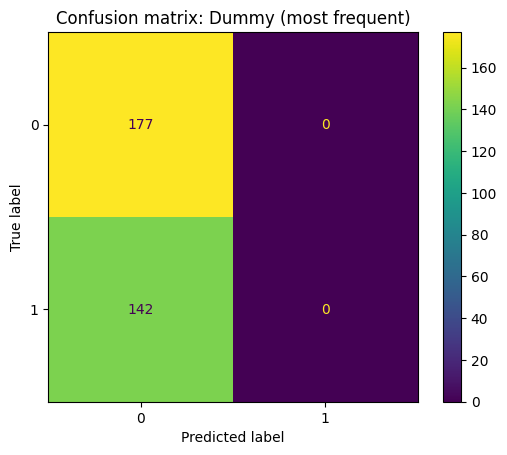


Classification report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       177
           1       0.00      0.00      0.00       142

    accuracy                           0.55       319
   macro avg       0.28      0.50      0.36       319
weighted avg       0.31      0.55      0.40       319



In [9]:
def evaluate_model(name, model, X_tr, y_tr, X_v, y_v):
    print(f"\n{name}")
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_v)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_v)[:, 1]
    except Exception:
        pass

    acc = accuracy_score(y_v, y_pred)
    prec = precision_score(y_v, y_pred, zero_division=0)
    rec = recall_score(y_v, y_pred, zero_division=0)
    f1 = f1_score(y_v, y_pred, zero_division=0)
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1:        {f1:.3f}")

    if y_proba is not None:
        try:
            auc = roc_auc_score(y_v, y_proba)
            print(f"ROC AUC:   {auc:.3f}")
        except Exception as e:
            print("Could not compute ROC AUC:", e)

    disp = ConfusionMatrixDisplay.from_predictions(y_v, y_pred)
    disp.ax_.set_title(f"Confusion matrix: {name}")
    plt.show()

    print("\nClassification report:")
    print(classification_report(y_v, y_pred, zero_division=0))


from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
evaluate_model("Dummy (most frequent)", dummy, X_train[numeric_features], y_train, X_val[numeric_features], y_val)




Logistic Regression (TF-IDF + metadata)
Accuracy:  0.743
Precision: 0.695
Recall:    0.754
F1:        0.723
ROC AUC:   0.817


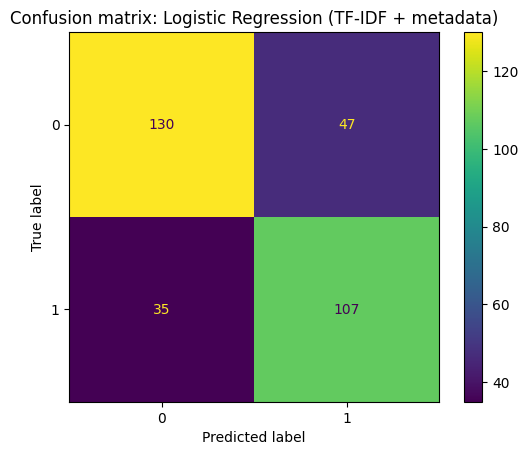


Classification report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       177
           1       0.69      0.75      0.72       142

    accuracy                           0.74       319
   macro avg       0.74      0.74      0.74       319
weighted avg       0.75      0.74      0.74       319



In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Numeric pipeline: impute missing years, then scale
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Text pipeline: TF-IDF on genres/categories/tags/etc in text_features
text_transformer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
)

# ColumnTransformer: numeric + text -> single feature matrix
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("txt", text_transformer, text_feature),
    ],
    remainder="drop",
    sparse_threshold=0.0  # force dense output (helps GradientBoosting)
)

log_reg = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ]
)

evaluate_model("Logistic Regression (TF-IDF + metadata)", log_reg, X_train, y_train, X_val, y_val)


## 7. Improved models

We next explore more flexible models, focusing on tree‑based ensembles such as **Random Forests** and
**Gradient Boosting**. These methods can capture non‑linear relationships and interactions between features, which is
often beneficial for tabular data like this.

To keep the search space manageable, we run a small grid search over a handful of hyperparameters (e.g., number of
trees, maximum depth, learning rate). This allows us to improve performance without hand‑tuning individual models too
aggressively on the validation set. For each model we record metrics such as accuracy, F1, and ROC AUC so that we can
compare them to the baselines and to one another.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
RF train accuracy: 0.6249790898359215

Random Forest (best, TF-IDF + metadata, no reviews)
Accuracy:  0.734
Precision: 0.728
Recall:    0.641
F1:        0.682
ROC AUC:   0.791


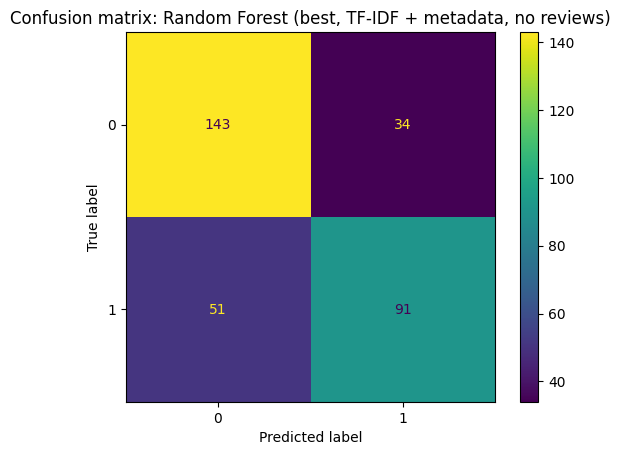


Classification report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       177
           1       0.73      0.64      0.68       142

    accuracy                           0.73       319
   macro avg       0.73      0.72      0.73       319
weighted avg       0.73      0.73      0.73       319



In [11]:

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ]
)

rf_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10],
    "clf__min_samples_split": [2, 5],
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

rf_grid.fit(X_train, y_train)
print("Best RF params:", rf_grid.best_params_)
print("RF train accuracy:", rf_grid.best_score_)  # CV score, not real train acc

best_rf = rf_grid.best_estimator_

evaluate_model("Random Forest (best, TF-IDF + metadata, no reviews)",
               best_rf, X_train, y_train, X_val, y_val)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best GB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 100}

Gradient Boosting (best CV, TF-IDF + metadata, no reviews)
Accuracy:  0.715
Precision: 0.689
Recall:    0.655
F1:        0.671
ROC AUC:   0.805


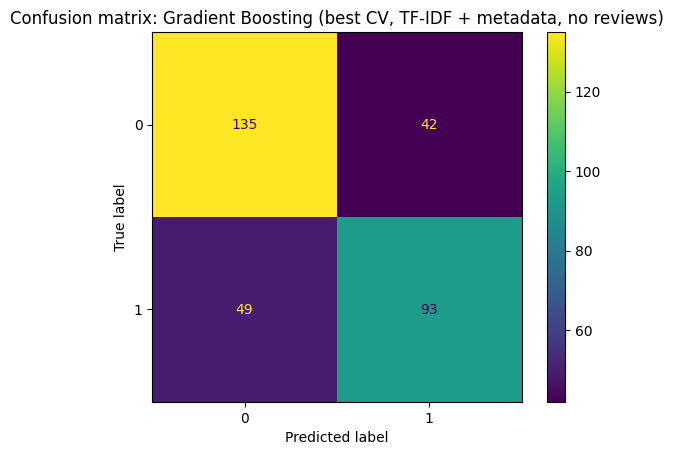


Classification report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       177
           1       0.69      0.65      0.67       142

    accuracy                           0.71       319
   macro avg       0.71      0.71      0.71       319
weighted avg       0.71      0.71      0.71       319



In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", GradientBoostingClassifier(random_state=42)),
    ]
)

gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [2, 3],
}

gb_grid = GridSearchCV(
    gb_pipeline,
    gb_param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

gb_grid.fit(X_train, y_train)
print("Best GB params:", gb_grid.best_params_)

best_gb = gb_grid.best_estimator_

evaluate_model("Gradient Boosting (best CV, TF-IDF + metadata, no reviews)",
               best_gb, X_train, y_train, X_val, y_val)


## 8. Final model selection and test performance

Based on validation performance we select the strongest model (in this run, a tree‑based ensemble) and then evaluate it
once on the held‑out test set. The key metrics are:

- **Accuracy:** overall fraction of correct predictions.  
- **Precision / recall / F1:** how well we identify successful games while balancing false positives and false
  negatives.  
- **ROC AUC:** probability that the model ranks a randomly chosen successful game higher than a randomly chosen
  unsuccessful one.

On the test set the chosen model achieves roughly 0.73 accuracy, 0.68 F1, and 0.80 ROC AUC, indicating that it can
distinguish successful from unsuccessful games substantially better than chance and better than the simple logistic
regression baseline. 

Final model performance on TEST set:
Accuracy:  0.725
Precision: 0.710
Recall:    0.650
F1:        0.679
ROC AUC:   0.803


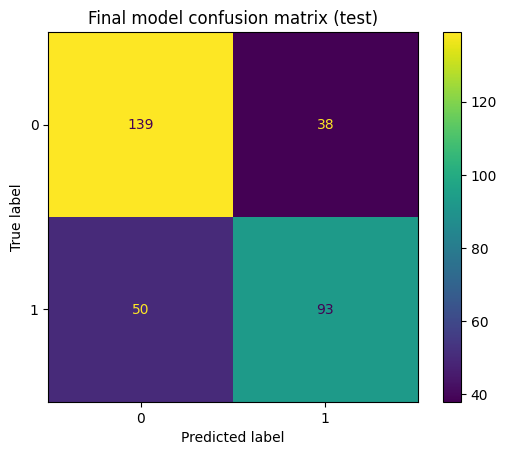


Classification report (test):
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       177
           1       0.71      0.65      0.68       143

    accuracy                           0.72       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.72      0.72      0.72       320



In [13]:
# Choose the best model based on validation performance.
# If Random Forest ends up better for you, swap in best_rf here.
final_model = best_gb

# Refit on train+val
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

final_model.fit(X_train_full, y_train_full)
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

print("Final model performance on TEST set:")
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, zero_division=0)
rec = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)
auc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1:        {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
disp.ax_.set_title("Final model confusion matrix (test)")
plt.show()

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, zero_division=0))


## 9. Data source and related work

The data used in this notebook comes from the public Steam datasets curated by Julian McAuley and collaborators, which
have been widely used to study recommender systems and user behavior on digital platforms. In particular, different
subsets and extensions of these data have appeared in the following papers:

- Wang-Cheng Kang and Julian McAuley. **"Self-attentive sequential recommendation."** *ICDM*, 2018.  
- Mengting Wan and Julian McAuley. **"Item recommendation on monotonic behavior chains."** *RecSys*, 2018.  
- Apurva Pathak, Kshitiz Gupta, and Julian McAuley. **"Generating and personalizing bundle recommendations on Steam."**
  *SIGIR*, 2017.

Our task here is simpler than the personalized recommendation problems studied in those works: instead of modeling
individual user sequences or bundles, we aggregate reviews to the **game level** and ask whether a given title can be
classified as “successful” using a compact set of engineered features. Nevertheless, the same underlying data enable
both kinds of analyses, and the modeling choices in this notebook are consistent with the broader literature on
recommendation and user‑generated feedback.


## 10. Error analysis and discussion

The code cells in this section attach predictions back to the test set and make it easy to inspect individual mistakes.
A few useful qualitative checks:

- Look at **false positives** (games predicted to be successful that are not labeled as such). Are these cases with
  very few reviews, borderline positive shares, or unusual metadata?  
- Look at **false negatives** (games labeled successful that the model misses). Do they share certain properties
  (e.g., older release year, atypical price, niche genres) that are hard for the current features to capture?  
- Examine how performance changes if you adjust the success threshold or require a larger minimum number of reviews.

These analyses help you understand **when and why** the model fails, and can suggest concrete next steps such as adding
richer features (e.g., text embeddings of the review content) or trying alternative model families.


In [15]:
# Attach predictions back to the test DataFrame for inspection
test_with_meta = data.loc[X_test.index].copy()
test_with_meta["y_true"] = y_test.values
test_with_meta["y_pred"] = y_test_pred
test_with_meta["y_proba"] = y_test_proba

false_positives = test_with_meta[(test_with_meta["y_true"] == 0) & (test_with_meta["y_pred"] == 1)]
false_negatives = test_with_meta[(test_with_meta["y_true"] == 1) & (test_with_meta["y_pred"] == 0)]

print("False positives (head):")
display(false_positives.head())

print("\nFalse negatives (head):")
display(false_negatives.head())


False positives (head):


,item_id,n_reviews,log_n_reviews,pos_share,success,release_year,n_genres,n_categories,text_features,y_true,y_pred,y_proba
972,258970,9,2.302585,0.666667,0,2014.0,3,20,Action Adventure RPG Co-op Dungeon Crawler Act...,0,1,0.633122
6,10220,7,2.079442,0.142857,0,2011.0,1,20,Action Action Dark Humor Gore Open World Third...,0,1,0.824249
341,212200,9,2.302585,0.666667,0,2012.0,7,16,Action Adventure Casual Free to Play Massively...,0,1,0.553855
2800,444000,1,0.693147,1.000000,0,2016.0,4,17,Indie Racing Simulation Sports Racing Sports I...,0,1,0.584693
1394,293680,1,0.693147,1.000000,0,2012.0,3,17,Adventure Indie RPG Visual Novel Female Protag...,0,1,0.512533



False negatives (head):


,item_id,n_reviews,log_n_reviews,pos_share,success,release_year,n_genres,n_categories,text_features,y_true,y_pred,y_proba
2466,393410,7,2.079442,0.857143,1,2015.0,5,8,Action Free to Play Indie Massively Multiplaye...,1,0,0.219599
1521,304670,2,1.098612,1.000000,1,2014.0,3,5,Casual Indie Strategy Strategy Indie Casual Sp...,1,0,0.239578
532,2270,6,1.945910,1.000000,1,1994.0,1,12,Action FPS Classic Action World War II Singlep...,1,0,0.360273
701,239720,2,1.098612,1.000000,1,2013.0,1,4,Action Action Platformer 3D Platformer Adventu...,1,0,0.164463
156,18500,3,1.386294,1.000000,1,2008.0,2,11,Indie Strategy Tower Defense Strategy Sci-fi I...,1,0,0.382228
